In [179]:
import numpy as np
import math
import collections
from math import ceil,log
import random
from collections import deque
from skimage import measure
from scipy import spatial

In [180]:
InputMatrixRow = 100
InputMatrixCol = 100
Positions = [[0, 10],[0, 40],[10,0],[0,90]]
speed = np.array([1,0.5,1,5])
coverage = np.array([5,2.5,2.5,1])
NumberOfRobots = len(Positions)

In [181]:
PositionOfObstacles = []
for x in range(30,50):
    for y in range(30,50):
        PositionOfObstacles.append([x, y])
#for x in range(10,50):
#   PositionOfObstacles.append([10, x])
#for x in range(0,70):
#    PositionOfObstacles.append([x, 70])
for x in range(30,50):
    for y in range(30,50):
        PositionOfObstacles.append([x, y])

In [182]:
#PositionOfObstacles = [[90, 90], [2, 2]]
obstacle = 0
if(len(PositionOfObstacles)>0):
    obstacle = 1

In [183]:
Matrix = np.ones([InputMatrixRow,InputMatrixCol], dtype = bool)

In [184]:
for y in PositionOfObstacles:
        Matrix[y[0],y[1]] = False

In [185]:
def neighboursA(x, y):
    for dx in [-1, 1]:
        yield x + dx, y
    for dy in [-1, 1]:
        yield x, y + dy

In [186]:
def floodfillA(is_path, x, y):
    height = len(is_path)
    width = len(is_path[0])

    grid = [[None] * width for _ in is_path]
    if not is_path[x][y]:
        # If we started in a wall, we can't reach anything
        return grid
    grid[x][y] = 0
    modified = deque([(x, y)])
    while modified:
        x, y = modified.popleft()
        number = grid[x][y]
        for dx, dy in neighboursA(x, y):
            if 0 <= dx < width and 0 <= dy < height and is_path[dx][dy] and grid[dx][dy] is None:
                grid[dx][dy] = number + 1
                modified.append((dx, dy))
    return grid

In [187]:
ans = floodfillA(Matrix, 0, 0)

In [188]:
def EvaluationMatrix():
    E = np.zeros([NumberOfRobots, InputMatrixRow, InputMatrixCol])
    for x in  range(NumberOfRobots):
        E[x] = floodfillA(Matrix,Positions[x][0], Positions[x][1])
    return(E)

In [189]:
E = EvaluationMatrix()

In [190]:
A = np.zeros([InputMatrixRow,InputMatrixCol])

In [191]:
def ArgMin():
    B = np.argmin(E,axis = 0)
    np.copyto(A,B)
    for x in PositionOfObstacles:
        A[x[0]][x[1]] = -1

In [192]:
ArgMin()

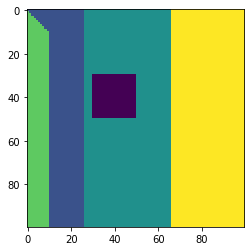

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline 
a = plt.imshow(A, interpolation='nearest')

In [194]:
LI = np.zeros([NumberOfRobots], dtype=int)

In [195]:
def L():
    unique, counts = np.unique(A, return_counts=True)
    if(obstacle):
        counts = counts[1:]
    np.copyto(LI,counts)

In [196]:
L()

In [197]:
UnoccupiedCells =  (InputMatrixCol*InputMatrixRow) -len(PositionOfObstacles)

In [198]:
FairShares = np.zeros([NumberOfRobots])
CombinedFactor = np.ones(NumberOfRobots)

In [199]:
def FairShareArray():
    CombinedFactor = np.multiply(speed, coverage)
    TotalWeight = np.sum(CombinedFactor)
    np.copyto(FairShares,CombinedFactor/TotalWeight)

In [200]:
FairShareArray()

In [201]:
def FairShare(index):
    ans = LI[index] - ((UnoccupiedCells)*FairShares[index])
    return(int(ans))

In [202]:
Digits = log((InputMatrixRow*InputMatrixCol),10)
c_main = pow(10,-ceil(Digits))

In [203]:
def MiCalculation(mi,index):
    Digits = log((InputMatrixRow*InputMatrixCol),10)
    c = pow(10,-(ceil(Digits)))
    mi = mi + c*(FairShare(index))
    return mi

In [204]:
m = np.ones([NumberOfRobots])
E_Temp = np.zeros([NumberOfRobots, InputMatrixRow, InputMatrixCol])

In [205]:
Digits = log((InputMatrixRow+InputMatrixCol),10)
c_con = pow(10,-ceil(Digits))
print(c_con)

0.001


In [206]:
def ContinuityCheckA():
    img,num  = measure.label(A, background=-1,return_num = True, connectivity = 1)
    if num == NumberOfRobots:
        return
    else:
        global obstacle
        obstacle_pt = 0 
        if(obstacle == 1):
            obstacle_pt = 1
        R = {}
        Q = {}
        ContinuityChecker = np.zeros(num)
        indicesAZ = np.indices(A.shape).T[:,:,[1, 0]]
        x_index = 0 
        for x in range(1,num+1):
            ContinuityChecker[x_index] = A[indicesAZ[img==x][0][0]][indicesAZ[img==x][0][1]]
            x_index = x_index + 1
        a = np.array(np.unique(ContinuityChecker, return_counts=True))
        for x in range(NumberOfRobots): #1, num to skip -1 of obstacle and 3 is number of robots change later
            if (a[1][x] > 1):
                label_traverse = int(a[0][x])
                q = []
                flag = 0 
                for y in range(num):
                    temp = []
                    if ContinuityChecker[y] == label_traverse:
                        start_pt = np.array([Positions[label_traverse][0],Positions[label_traverse][1]])
                        if(any(np.equal(indicesAZ[img==y+1],start_pt).all(1))):
                            R[label_traverse] = [indicesAZ[img==(y+1)]]
                        else:
                            temp = indicesAZ[img==(y+1)]
                            q.append(temp)
                Q[label_traverse] = q
                ro = R[label_traverse]
                qo = Q[label_traverse]
                ro_new = np.array(ro[0])
                qo_new = np.array(qo[0])
                for ter in range(1,len(qo)):
                    temp  = np.array(qo[ter])
                ro_tree = spatial.KDTree(ro_new)
                qo_tree = spatial.KDTree(qo_new)
                c = np.ones([InputMatrixRow,InputMatrixCol])
                for i in range(InputMatrixRow):
                    for j in range(InputMatrixCol):
                        distance_r, index_r = ro_tree.query([i,j])
                        distance_q, index_q = qo_tree.query([i,j])
                        c[i,j] = (abs(ro_new[index_r][0]-i)+ abs(ro_new[index_r][1]-j)) - (abs(qo_new[index_q][0]-i) + abs(qo_new[index_q][1]-j))
                c = 1 + c*c_con
                MulAns = np.multiply(c,E[label_traverse]) # do the freeze
                E[label_traverse]= MulAns   

In [207]:
def MiStep():
    L()
    for x in range(NumberOfRobots):
        m[x] = MiCalculation(1,x)
        E[x] = E[x]*m[x]
    ArgMin()

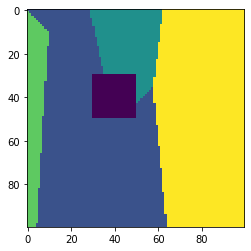

In [208]:
for x in range(1,200):
    MiStep()
    if(x%10==0):
        ContinuityCheckA()
plt.imshow(A, interpolation='nearest')

In [209]:
MiStep()

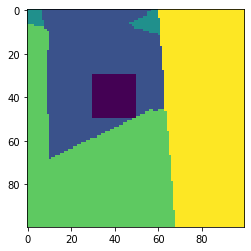

In [178]:
plt.imshow(A, interpolation='nearest')